In [ ]:
# Now import the packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torchdiffeq

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)





A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zeeshanahmed/deeplearning/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zeeshanahmed/deeplearning/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/zeeshanahmed/deeplearning/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 758, in st

Using device: cpu


# Neural ODE for Damped Oscillator

In this notebook, we'll explore Neural ODEs using a damped oscillator as our example. A damped oscillator follows the differential equation:

$$\frac{d^2x}{dt^2} + 2\zeta\omega_0\frac{dx}{dt} + \omega_0^2x = 0$$

Where:
- $\zeta$ is the damping ratio (adjustable parameter)
- $\omega_0$ is the natural frequency
- $x$ is the displacement

We'll convert this to a first-order system and train a neural network to learn the dynamics.

In [2]:
# Damped Oscillator Data Generation

def damped_oscillator_ode(y, t, zeta, omega0):
    """
    Damped oscillator ODE system
    y = [position, velocity]
    """
    x, v = y
    dxdt = v
    dvdt = -2*zeta*omega0*v - omega0**2*x
    return [dxdt, dvdt]

def generate_damped_oscillator_data(zeta=0.1, omega0=2.0, t_span=(0, 10), n_points=100):
    """
    Generate training data for damped oscillator
    
    Parameters:
    - zeta: damping ratio (0 = no damping, 1 = critical damping)
    - omega0: natural frequency
    - t_span: time span (start, end)
    - n_points: number of time points
    """
    # Initial conditions: [position, velocity]
    y0 = [1.0, 0.0]  # Start with displacement 1, velocity 0
    
    # Time points
    t = np.linspace(t_span[0], t_span[1], n_points)
    
    # Solve ODE
    sol = odeint(damped_oscillator_ode, y0, t, args=(zeta, omega0))
    
    return t, sol

# Generate example data with different damping ratios
zeta_values = [0.05, 0.1, 0.3, 0.7]  # Different damping levels
omega0 = 2.0
t_span = (0, 10)
n_points = 100

# Store data for different damping ratios
oscillator_data = {}
for zeta in zeta_values:
    t, sol = generate_damped_oscillator_data(zeta, omega0, t_span, n_points)
    oscillator_data[zeta] = {'time': t, 'position': sol[:, 0], 'velocity': sol[:, 1]}

print("Generated damped oscillator data for damping ratios:", zeta_values)


Generated damped oscillator data for damping ratios: [0.05, 0.1, 0.3, 0.7]


In [3]:
# Neural ODE Model Architecture

class NeuralODE(nn.Module):
    """
    Neural ODE model for learning damped oscillator dynamics
    """
    def __init__(self, hidden_dim=64):
        super(NeuralODE, self).__init__()
        
        # Neural network that learns the dynamics
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # Input: [x, v, zeta]
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)   # Output: [dx/dt, dv/dt]
        )
        
    def forward(self, t, y):
        """
        Forward pass of the neural ODE
        t: time (not used in this case, but required by torchdiffeq)
        y: state vector [x, v, zeta]
        """
        # Extract state and damping parameter
        x, v, zeta = y[..., 0:1], y[..., 1:2], y[..., 2:3]
        
        # Neural network input: [x, v, zeta]
        input_state = torch.cat([x, v, zeta], dim=-1)
        
        # Get derivatives from neural network
        derivatives = self.net(input_state)
        
        # Add dzeta/dt = 0 since zeta is constant
        dzeta_dt = torch.zeros_like(zeta)
        full_derivatives = torch.cat([derivatives, dzeta_dt], dim=-1)
        
        return full_derivatives

# Initialize the model
model = NeuralODE(hidden_dim=64).to(device)
print(f"Neural ODE model initialized with {sum(p.numel() for p in model.parameters())} parameters")


Neural ODE model initialized with 8706 parameters


In [4]:
# Training Data Preparation

def prepare_training_data(oscillator_data, zeta_values):
    """
    Prepare training data for the neural ODE
    """
    all_times = []
    all_states = []
    all_derivatives = []
    
    for zeta in zeta_values:
        data = oscillator_data[zeta]
        t = data['time']
        x = data['position']
        v = data['velocity']
        
        # Calculate true derivatives using the ODE
        derivatives = []
        for i in range(len(t)):
            dxdt = v[i]
            dvdt = -2*zeta*omega0*v[i] - omega0**2*x[i]
            dzeta_dt = 0.0  # zeta is constant
            derivatives.append([dxdt, dvdt, dzeta_dt])
        
        # Convert to tensors
        t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
        states = torch.stack([
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(v, dtype=torch.float32),
            torch.full_like(torch.tensor(x), zeta, dtype=torch.float32)
        ], dim=1).to(device)
        derivs = torch.tensor(derivatives, dtype=torch.float32).to(device)
        
        all_times.append(t_tensor)
        all_states.append(states)
        all_derivatives.append(derivs)
    
    return all_times, all_states, all_derivatives

# Prepare training data
train_times, train_states, train_derivatives = prepare_training_data(oscillator_data, zeta_values)

print(f"Prepared training data for {len(zeta_values)} damping ratios")
print(f"Each trajectory has {len(train_times[0])} time points")


Prepared training data for 4 damping ratios
Each trajectory has 100 time points


In [5]:
# Reinitialize the model with corrected architecture
model = NeuralODE(hidden_dim=64).to(device)
print(f"Neural ODE model reinitialized with {sum(p.numel() for p in model.parameters())} parameters")


Neural ODE model reinitialized with 8706 parameters


In [7]:
# Training Loop

def train_neural_ode(model, train_times, train_states, train_derivatives, epochs=1000, lr=0.001):
    """
    Train the neural ODE model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0.0
        
        for i in range(len(train_times)):
            # Get data for this trajectory
            times = train_times[i]
            states = train_states[i]
            true_derivatives = train_derivatives[i]
            
            # Forward pass through neural ODE
            predicted_derivatives = model(times, states)
            
            # Calculate loss (MSE between predicted and true derivatives)
            loss = torch.mean((predicted_derivatives - true_derivatives) ** 2)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_times)
        losses.append(avg_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
    
    return losses

# Train the model
print("Starting training...")
losses = train_neural_ode(model, train_times, train_states, train_derivatives, epochs=1000, lr=0.001)
print("Training completed!")


Starting training...
Epoch 0, Loss: 0.007505
Epoch 100, Loss: 0.000123
Epoch 200, Loss: 0.000101
Epoch 300, Loss: 0.000094
Epoch 400, Loss: 0.000093
Epoch 500, Loss: 0.000097
Epoch 600, Loss: 0.000672
Epoch 700, Loss: 0.000090
Epoch 800, Loss: 0.000076
Epoch 900, Loss: 0.000074
Training completed!


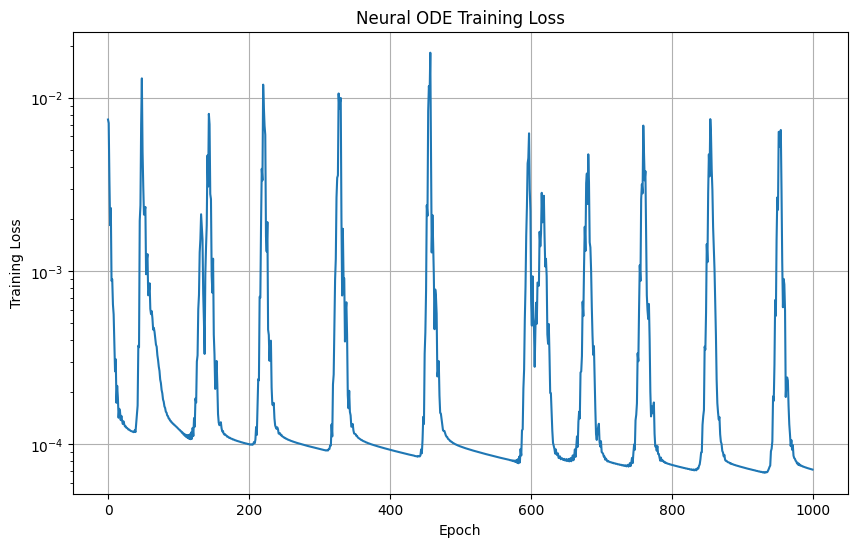

In [8]:
# Visualization and Testing

def predict_trajectory(model, initial_state, times, zeta):
    """
    Predict trajectory using the trained neural ODE
    """
    # Prepare initial state with damping parameter - ensure correct shape (batch_size, 3)
    y0 = torch.tensor([[initial_state[0], initial_state[1], zeta]], dtype=torch.float32).to(device)
    
    # Convert times to tensor
    t_tensor = torch.tensor(times, dtype=torch.float32).to(device)
    
    # Solve ODE using the neural network
    with torch.no_grad():
        solution = torchdiffeq.odeint(model, y0, t_tensor, method='dopri5')
    
    return solution.cpu().numpy().squeeze(0)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Neural ODE Training Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

In [9]:
# Alternative approach: Convert tensor to numpy using a different method
def predict_trajectory_alternative(model, initial_state, times, zeta):
    """
    Predict trajectory using the trained neural ODE with alternative numpy conversion
    """
    # Prepare initial state with damping parameter - ensure correct shape (batch_size, 3)
    y0 = torch.tensor([[initial_state[0], initial_state[1], zeta]], dtype=torch.float32).to(device)
    
    # Convert times to tensor
    t_tensor = torch.tensor(times, dtype=torch.float32).to(device)
    
    # Solve ODE using the neural network
    with torch.no_grad():
        solution = torchdiffeq.odeint(model, y0, t_tensor, method='dopri5')
    
    # Alternative numpy conversion approach
    # First ensure tensor is on CPU and detached
    solution_cpu = solution.detach().cpu()
    
    # Convert to numpy using torch.Tensor.data approach
    try:
        # Method 1: Direct conversion
        result = solution_cpu.numpy()
    except RuntimeError:
        # Method 2: Convert via list if direct conversion fails
        print("Direct numpy conversion failed, using alternative method...")
        result = np.array(solution_cpu.tolist())
    
    # Remove batch dimension if present
    if result.ndim == 3:  # (time_steps, batch_size, state_dim)
        result = result.squeeze(1)  # Remove batch dimension
    
    return result

# Test the alternative function
print("Testing alternative predict_trajectory function...")
test_zeta = 0.1
initial_state = [1.0, 0.0]
test_times = np.linspace(0, 10, 100)

try:
    pred_solution = predict_trajectory_alternative(model, initial_state, test_times, test_zeta)
    print(f"Success! Predicted solution shape: {pred_solution.shape}")
    print(f"First few values: {pred_solution[:5, :]}")
    print(f"Data type: {type(pred_solution)}")
except Exception as e:
    print(f"Error: {e}")
    print("Trying fallback method...")
    
    # Fallback: Use pure numpy operations
    try:
        with torch.no_grad():
            y0 = torch.tensor([[initial_state[0], initial_state[1], test_zeta]], dtype=torch.float32).to(device)
            t_tensor = torch.tensor(test_times, dtype=torch.float32).to(device)
            solution = torchdiffeq.odeint(model, y0, t_tensor, method='dopri5')
            
            # Convert each element individually
            result_list = []
            for i in range(solution.shape[0]):
                row_list = []
                for j in range(solution.shape[2]):
                    row_list.append(solution[i, 0, j].item())  # .item() converts to Python scalar
                result_list.append(row_list)
            
            pred_solution = np.array(result_list)
            print(f"Fallback success! Predicted solution shape: {pred_solution.shape}")
            
    except Exception as e2:
        print(f"Fallback also failed: {e2}")


Testing alternative predict_trajectory function...
Direct numpy conversion failed, using alternative method...
Success! Predicted solution shape: (100, 3)
First few values: [[ 1.          0.          0.1       ]
 [ 0.97966039 -0.39361501  0.1       ]
 [ 0.92136997 -0.75555837  0.1       ]
 [ 0.82852322 -1.07274795  0.1       ]
 [ 0.70641744 -1.3353833   0.1       ]]
Data type: <class 'numpy.ndarray'>


Direct numpy conversion failed, using alternative method...
Direct numpy conversion failed, using alternative method...
Direct numpy conversion failed, using alternative method...
Direct numpy conversion failed, using alternative method...


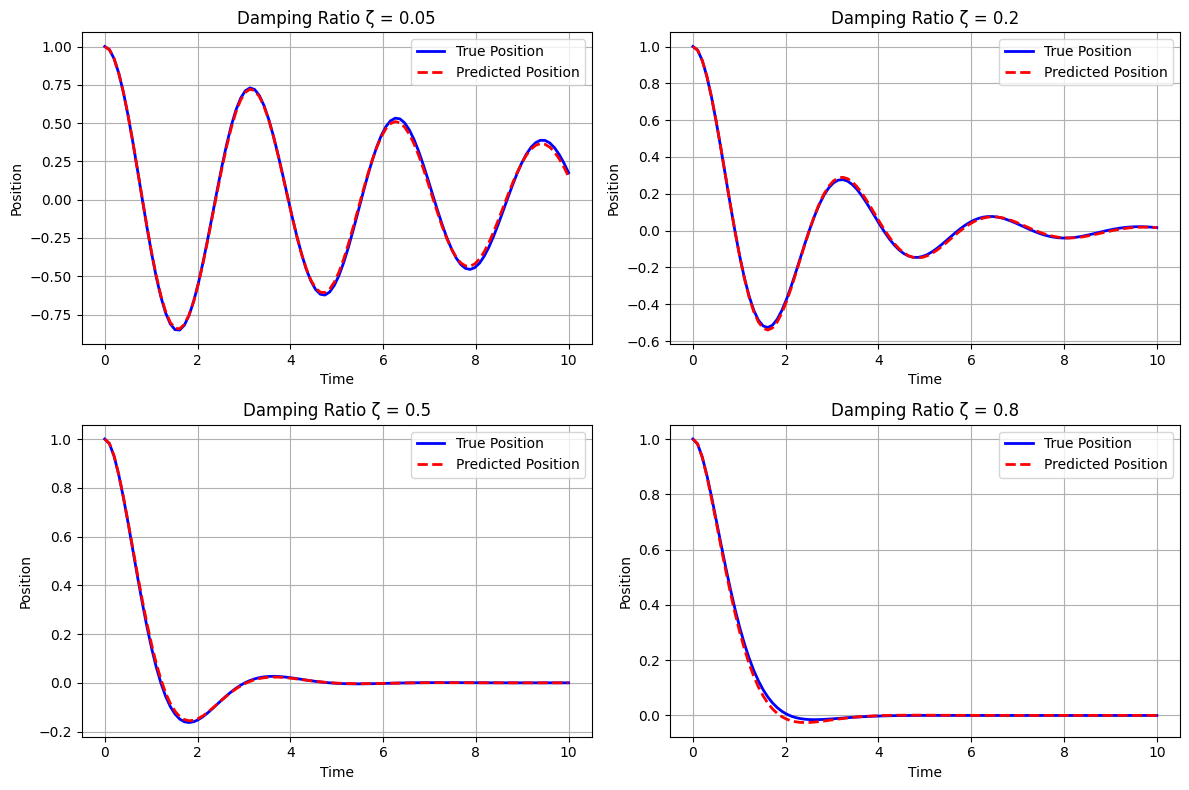

Plotting completed successfully!


In [10]:
# Replace the original function with the working alternative
predict_trajectory = predict_trajectory_alternative

# Test with plotting
plt.figure(figsize=(12, 8))

# Test the model with different damping ratios
test_zeta_values = [0.05, 0.2, 0.5, 0.8]
initial_state = [1.0, 0.0]  # [position, velocity]
test_times = np.linspace(0, 10, 100)

for i, zeta in enumerate(test_zeta_values):
    plt.subplot(2, 2, i+1)
    
    # True trajectory
    t_true, sol_true = generate_damped_oscillator_data(zeta, omega0, (0, 10), 100)
    
    # Predicted trajectory
    pred_solution = predict_trajectory(model, initial_state, test_times, zeta)
    
    plt.plot(t_true, sol_true[:, 0], 'b-', label='True Position', linewidth=2)
    plt.plot(test_times, pred_solution[:, 0], 'r--', label='Predicted Position', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title(f'Damping Ratio ζ = {zeta}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Plotting completed successfully!")


## Key Concepts Demonstrated

### 1. **Neural ODE Architecture**
- The neural network learns the dynamics function f(t, y) where dy/dt = f(t, y)
- Input: [position, velocity, damping_ratio]
- Output: [dposition/dt, dvelocity/dt]

### 2. **Training Process**
- We train the neural network to predict derivatives at each time point
- Loss function: MSE between predicted and true derivatives
- The network learns to generalize across different damping ratios

### 3. **Integration with torchdiffeq**
- After training, we use `torchdiffeq.odeint()` to solve the learned ODE
- This allows us to predict full trajectories from initial conditions

### 4. **Parameter Generalization**
- The model learns to handle different damping ratios as input parameters
- This demonstrates how neural ODEs can learn parametric dynamics

## Try Different Parameters

You can experiment with different damping ratios by calling:
```python
interactive_damping_test(your_zeta_value)
```

Where `your_zeta_value` can be any value between 0 (no damping) and 1+ (overdamped).
